# Exploratory data analysis

In [261]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Data loading

In [262]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Check for null values and duplicates (there are actually none in this dataset).

In [264]:
# No null values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [265]:
# No duplicates
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Drop irrelevant columns for data analysis

In [266]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Correlations across the dataset

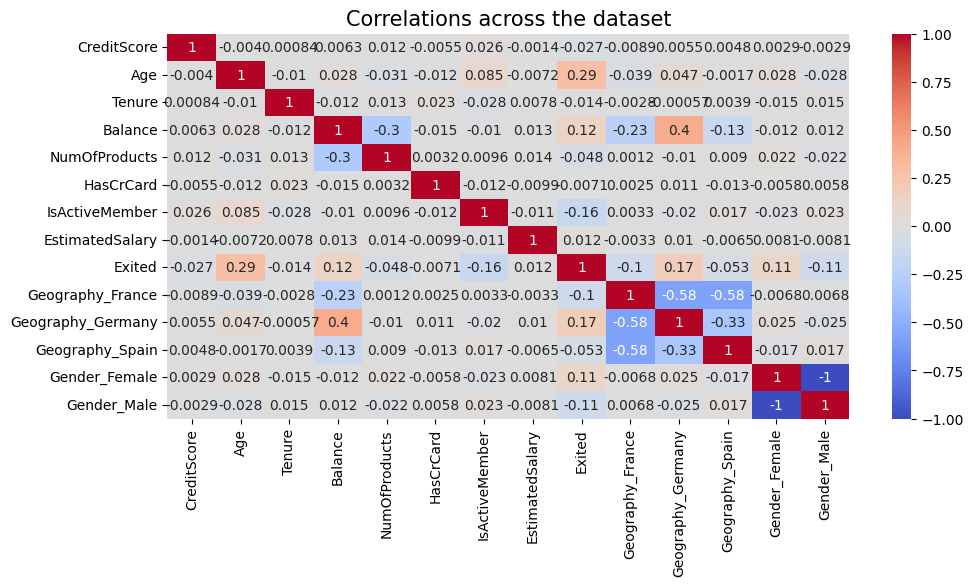

In [267]:
# Convert categorical variables into dummy variables
df_plot = pd.get_dummies(df)

# Compute correlations
correlations = df_plot.corr(numeric_only=True)

# Plot
plt.figure(figsize=(11,5))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title('Correlations across the dataset', fontsize=15)
plt.savefig(os.path.join(output_directory, '1_1_correlation_heatmap.png'),
            bbox_inches='tight', dpi=600)
plt.show()

There are little correlations throughout the dataset. Nevertheless, let us take a look at a few variables that may be relevant to the `Exited` column, which indicates if a customer has stayed/left with the bank, namely:
- `Gender`.
- `Geography`.
- `Age`.

We will also take a look at `Tenure`, which indicates the number of years for which a customer has been with the bank. This will facilitate disentangling the age from the time spent as a customer at the bank (although we already see in the above figure that `Age` is more correlated to `Exited` than `Tenure`). 

## Churn distributions

### Useful function

In [268]:
def get_exit_proportion(df: pd.DataFrame,
                        column_name: str,
                        *,
                        sort_final: bool = True) -> pd.DataFrame:
    """
    Generate a table grouped by column_name with:
        - the total customer count ('total_count').
        - the count of customers that have exited ('exit_count').
        - the proportion of customers that have exited ('exit_proportion').

    If sort_final is True, the final dataframe is sorted by descending exit proportion.
    """

    # Compute total count
    df_count = df[column_name].value_counts().copy()
    df_count = df_count.reset_index(name='total_count')

    # Compute exit count
    df_exit = df[df['Exited'] == 1].groupby(column_name).size()
    df_exit = df_exit.reset_index(name='exit_count')

    # Merge tables
    df_final = pd.merge(df_count, df_exit, on=column_name, how='left')

    # Compute exit proportions
    df_final['exit_proportion'] = 100*df_final['exit_count']/df_final['total_count']

    # Sort according to exit proportion
    if sort_final:
        df_final = df_final.sort_values('exit_proportion', ascending=False)
        df_final = df_final.reset_index(drop=True)

    return df_final

### Gender and geography

In [269]:
df_gender = get_exit_proportion(df, 'Gender')
df_gender


,Gender,total_count,exit_count,exit_proportion
0,Female,4543,1139,25.071539
1,Male,5457,898,16.455928


In [270]:
df_geography = get_exit_proportion(df, 'Geography')
df_geography

,Geography,total_count,exit_count,exit_proportion
0,Germany,2509,814,32.443204
1,Spain,2477,413,16.673395
2,France,5014,810,16.154767


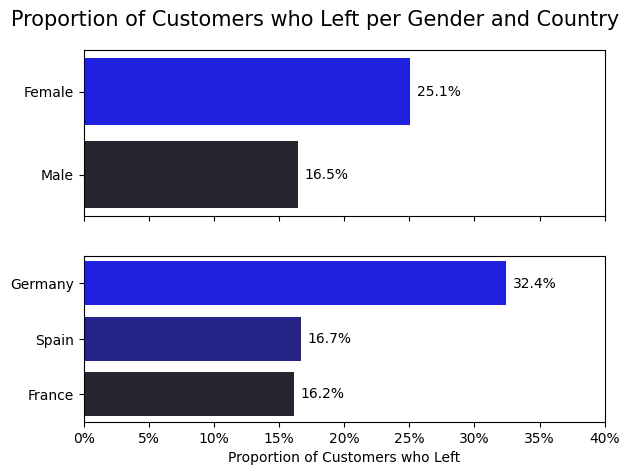

In [271]:
# Plot
fig, ax = plt.subplots(2, 1)

sns.barplot(df_gender, x='exit_proportion', y='Gender', ax=ax[0],
            hue='Gender', palette='dark:b_r')
# Add values to bars
for idx, val in enumerate(df_gender['exit_proportion']):
        ax[0].text(val+0.5, idx, f'{val:.1f}%', va='center')
ax[0].set_xlim([0, 40])
ax[0].set_xticklabels([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')

sns.barplot(df_geography, x='exit_proportion', y='Geography', ax=ax[1],
            hue='Geography', palette='dark:b_r')
for idx, val in enumerate(df_geography['exit_proportion']):
        ax[1].text(val+0.5, idx, f'{val:.1f}%', va='center') 
ax[1].set_xlim(ax[0].get_xlim())
ax[1].xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax[1].set_ylabel('')
ax[1].set_xlabel('Proportion of Customers who Left')

plt.suptitle('Proportion of Customers who Left per Gender and Country',
             fontsize=15)
plt.tight_layout(h_pad=2.5)
plt.savefig(os.path.join(output_directory, '1_2_churn_proportion_gender_country.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- There is a larger proportion of female customers than male customers that have left the bank.
- There are twice as many German customers that have left the bank as there are Spanish or French ones. 

### Age and tenure

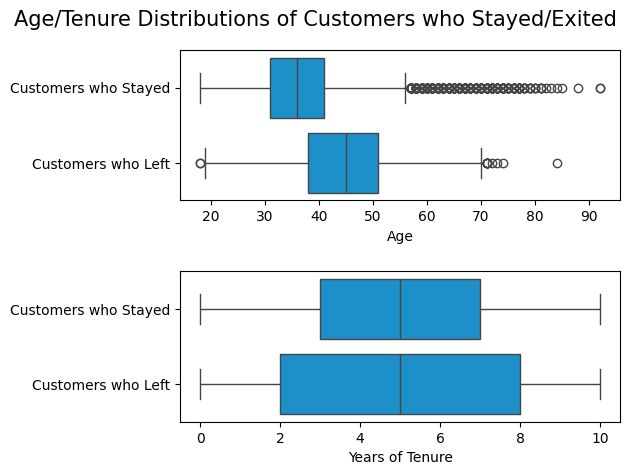

In [290]:
df_plot = df.copy()

df_plot['Exited'] = df_plot['Exited'].replace(0, 'Customers who Stayed')
df_plot['Exited'] = df_plot['Exited'].replace(1, 'Customers who Left')

fig, ax = plt.subplots(2, 1)

sns.boxplot(df_plot, x='Age', y='Exited',
            orient='h', ax=ax[0], color=[0, 0.6, 0.9])
ax[0].invert_yaxis()
ax[0].set_ylabel('')

sns.boxplot(df_plot, x='Tenure', y='Exited',
            orient='h', ax=ax[1], color=[0, 0.6, 0.9])
ax[1].invert_yaxis()
ax[1].set_ylabel('')
ax[1].set_xlabel('Years of Tenure')

plt.suptitle('Age/Tenure Distributions of Customers who Stayed/Exited', fontsize=15)
plt.tight_layout(h_pad=2)
plt.savefig(os.path.join(output_directory, '1_3_age_tenure_distributions.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- Customers who left the bank were typically older than customers who stayed.
- This age discrepancy does not seem to be related to the years of tenure, which are uncorrelated with leaving the bank.
    - This is also apparent in the correlation heatmap above.